In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from omegaconf import DictConfig, OmegaConf
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # ensure plotly>=4.8.1
from ipywidgets import interactive, interact, FloatSlider, ToggleButtons, HBox, VBox, Layout, IntSlider, interactive_output
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from DataInit import DataManager, RewardDataManager
import DataInit

In [2]:
# config manager
config = DataInit.config_manager()

# path manager
global_path, data_path, load_latency_original_csv_path, rewards_npy_path, models_pkl_path = DataInit.path_manager(config)


---------- Config Info ----------
path:
  global_path: /home/alex4060/PythonProject/MScProject/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda_load: 0.5
  top_k:
  - 1
  - 2
  - 3
  - 4
  - 5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_std: 10.0
    node_load_iid_std: 5.0
    node_load_ar1_theta: 0.9
    node_load_ar1_std: 80.0
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_std: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 30.0
      alpha_latency_1: 0.035
    ar1:
      alpha_load_0: 30.0
      alpha_latency_1: 0.086
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
   

# Reward optimisation attempt

In [4]:
class RewardDataProcessor:
    def __init__(self, load_latency_original_csv_path: Path, reward_parameters_slider: DictConfig) -> None:
        # load original data
        self.iid_load = pd.read_csv(load_latency_original_csv_path / 'load_iid_data.csv').to_numpy()
        self.iid_latency = pd.read_csv(load_latency_original_csv_path / 'latency_iid_data.csv').to_numpy()
        self.ar1_load = pd.read_csv(load_latency_original_csv_path / 'load_ar1_data.csv').to_numpy()
        self.ar1_latency = pd.read_csv(load_latency_original_csv_path / 'latency_ar1_data.csv').to_numpy()

        # save reward parameters
        self.alpha_load_0_value = reward_parameters_slider.alpha_load_0.value
        self.alpha_load_0_min = reward_parameters_slider.alpha_load_0.min
        self.alpha_load_0_max = reward_parameters_slider.alpha_load_0.max
        self.alpha_load_0_step = reward_parameters_slider.alpha_load_0.step
        self.alpha_load_0_description = reward_parameters_slider.alpha_load_0.description
        
        self.alpha_latency_0_value = reward_parameters_slider.alpha_latency_0.value
        self.alpha_latency_0_min = reward_parameters_slider.alpha_latency_0.min
        self.alpha_latency_0_max = reward_parameters_slider.alpha_latency_0.max
        self.alpha_latency_0_step = reward_parameters_slider.alpha_latency_0.step
        self.alpha_latency_0_description = reward_parameters_slider.alpha_latency_0.description
        
        self.alpha_latency_1_value = reward_parameters_slider.alpha_latency_1.value
        self.alpha_latency_1_min = reward_parameters_slider.alpha_latency_1.min
        self.alpha_latency_1_max = reward_parameters_slider.alpha_latency_1.max
        self.alpha_latency_1_step = reward_parameters_slider.alpha_latency_1.step
        self.alpha_latency_1_description = reward_parameters_slider.alpha_latency_1.description

    def calculate_reward(self, data: np.ndarray, method: str, alpha: float = 1) -> np.ndarray:
        if method == 'load_0' or method == 'latency_0':
            return alpha / (1 + data)
        elif method == 'load_1':
            inverted_data = 1 / (1 + data)
            normalized_data = (inverted_data - inverted_data.min(axis=0)) / (inverted_data.max(axis=0) - inverted_data.min(axis=0))
            return normalized_data
        elif method == 'latency_1':
            return np.exp(-alpha * data)
        else:
            raise ValueError(f"Unknown method: {method}")

    
    def calculate_subtitle(self, data: np.ndarray, title: str = "") -> str:
        mean_values = np.mean(data, axis=1)
        range_value = np.max(mean_values) - np.min(mean_values)
        sorted_indices = np.argsort(-mean_values)
        sorted_nodes = ", ".join(map(str, sorted_indices))
        return f"{title}<br>range: {range_value:.3f}<br>{sorted_nodes}"

    def plot_single_mean(self, fig, data: np.ndarray, row: int, col: int, dynamic_y: bool = False, title: str = ''):
        mean_values = np.mean(data, axis=1)
        
        # calculate the range of y values
        y_max, y_min = np.max(mean_values), np.min(mean_values)
        range_value = y_max - y_min

        # find the index of the maximum and minimum values
        max_index, min_index = np.argmax(mean_values), np.argmin(mean_values)
    
        # add a trace for the mean values
        fig.add_trace(go.Scatter(x=np.arange(len(mean_values)), y=mean_values, 
                                 mode='lines+markers', name=title), row=row, col=col)

        # a
        fig.add_annotation(x=max_index, y=y_max, text=f'Max: {y_max:.3f} at x={max_index}',
                           showarrow=True, arrowhead=2, font=dict(color="red"), 
                           row=row, col=col)
        fig.add_annotation(x=min_index, y=y_min, text=f'Min: {y_min:.3f} at x={min_index}',
                           showarrow=True, arrowhead=2, font=dict(color="blue"),
                           row=row, col=col)

        # format the layout, including the title, axis labels, and grid, and set the y-axis range
        y_range = [0, 1] if dynamic_y and y_min >= 0 and y_max <= 1 else [y_min - 0.1 * range_value, y_max + 0.1 * range_value]

    
    def plot_mean_values(self, alpha_load_0: float, alpha_latency_0: float, alpha_latency_1: float, dynamic_y: bool = False, data_method: str = 'iid'):
        data_map = {'iid': (self.iid_load, self.iid_latency), 'ar1': (self.ar1_load, self.ar1_latency)}
        load_data, latency_data = data_map[data_method]

        rewards = {
            'Load Original data': load_data,
            'Load Reward 0': self.calculate_reward(load_data, 'load_0', alpha_load_0),
            'Load Reward 1': self.calculate_reward(load_data, 'load_1'),
            'Latency Original data': latency_data,
            'Latency Reward 0': self.calculate_reward(latency_data, 'latency_0', alpha_latency_0),
            'Latency Reward 1': self.calculate_reward(latency_data, 'latency_1', alpha_latency_1)
        }

        # create a figure with 2 rows and 3 columns, and set the subplot titles
        fig = make_subplots(rows=2, cols=3, subplot_titles=[self.calculate_subtitle(rewards[key], title=key) for key in rewards])

        # plot the mean values for each reward type
        for i, (title, data) in enumerate(rewards.items()):
            self.plot_single_mean(fig, data, row=i // 3 + 1, col=i % 3 + 1, dynamic_y=dynamic_y, title=title)
   
        # add a title to the figure, and adjust the layout to make it look better
        fig.update_layout(
            height=500, 
            width=1000, 
            title_text="Mean Values across Different Rewards",
            title_y=0.98,  # title is 98% of the way up the figure
            title_x=0.5,  # title is centered horizontally
            title_xanchor='center',  # ensure the text is centered
            margin=dict(t=100)  # add some space at the top of the figure
        )
    
        fig.show()

    
    def calculate_range_over_alpha(self, alpha_load_0, alpha_latency_0, alpha_latency_1):
        ranges = {'iid': {}, 'ar1': {}}
        for method in ['iid', 'ar1']:
            load_data, latency_data = (self.iid_load, self.iid_latency) if method == 'iid' else (self.ar1_load, self.ar1_latency)
            ranges[method]['load_reward_0'] = [np.ptp(self.calculate_reward(load_data, 'load_0', alpha).mean(axis=1)) for alpha in alpha_load_0]
            ranges[method]['latency_reward_0'] = [np.ptp(self.calculate_reward(latency_data, 'latency_0', alpha).mean(axis=1)) for alpha in alpha_latency_0]
            ranges[method]['latency_reward_1'] = [np.ptp(self.calculate_reward(latency_data, 'latency_1', alpha).mean(axis=1)) for alpha in alpha_latency_1]
        return ranges

    def plot_range_vs_alpha(self, alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1):
        ranges = self.calculate_range_over_alpha(alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1)
        fig, axs = plt.subplots(2, 3, figsize=(18, 6))

        def add_plot(ax, alpha_values, ranges, title, color):
            ax.plot(alpha_values, ranges, marker='o', linestyle='-', color=color)
            ax.set_title(title)
            ax.set_xlabel('Alpha')
            ax.set_ylabel('Range (Max - Min)')
            ax.grid(True)

            # find the maximum and minimum values and their indices
            max_value = np.max(ranges)
            min_value = np.min(ranges)
            max_index = np.argmax(ranges)
            min_index = np.argmin(ranges)
    
            # Indicate the positions of the maximum and minimum values in the figure.
            ax.annotate(f'Max range: {max_value:.3f} at alpha={alpha_values[max_index]:.3f}',
                        xy=(alpha_values[max_index], max_value), 
                        xycoords='data',
                        xytext=(alpha_values[max_index], max_value + 0.05 * max_value), 
                        textcoords='data',
                        arrowprops=dict(arrowstyle="->", lw=1.5, color='red'),
                        color='red')
    
            ax.annotate(f'Min range: {min_value:.3f} at alpha={alpha_values[min_index]:.3f}',
                        xy=(alpha_values[min_index], min_value), 
                        xycoords='data',
                        xytext=(alpha_values[min_index], min_value - 0.05 * min_value), 
                        textcoords='data',
                        arrowprops=dict(arrowstyle="->", lw=1.5, color='blue'),
                        color='blue')

        add_plot(axs[0, 0], alpha_values_load_0, ranges['iid']['load_reward_0'], 'IID Load Reward 0 vs Alpha', 'b')
        add_plot(axs[0, 1], alpha_values_latency_0, ranges['iid']['latency_reward_0'], 'IID Latency Reward 0 vs Alpha', 'g')
        add_plot(axs[0, 2], alpha_values_latency_1, ranges['iid']['latency_reward_1'], 'IID Latency Reward 1 vs Alpha', 'r')
        add_plot(axs[1, 0], alpha_values_load_0, ranges['ar1']['load_reward_0'], 'AR1 Load Reward 0 vs Alpha', 'b')
        add_plot(axs[1, 1], alpha_values_latency_0, ranges['ar1']['latency_reward_0'], 'AR1 Latency Reward 0 vs Alpha', 'g')
        add_plot(axs[1, 2], alpha_values_latency_1, ranges['ar1']['latency_reward_1'], 'AR1 Latency Reward 1 vs Alpha', 'r')

        plt.tight_layout()
        plt.show()

            
    def plot_distributions(self, axs, load_data, start, end, title='Load Data', row=0):
        for i in range(start, end):
            axs[row, 0].plot(load_data[i], label=f'Node {i}')
        axs[row, 0].set_title(title)
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel('Load')
        axs[row, 0].legend()
        axs[row, 0].grid(True)

        mean_values = np.mean(load_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label='Mean Load per Node')
        axs[row, 1].set_title(f'{title} - Mean Values')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel('Mean Load')
        axs[row, 1].legend()
        axs[row, 1].grid(True)

        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min

        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')

        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()

        for i in range(start, end):
            axs[row, 2].hist(load_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i}')
        axs[row, 2].set_title(f'{title} - Histogram')
        axs[row, 2].set_xlabel('Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)

    def plot_all_distributions(self, alpha_load=1.0, alpha_latency_0=1.0, alpha_latency_1=1.0, start=0, end=3, data_method='iid'):
        data_map = {'iid': (self.iid_load, self.iid_latency), 'ar1': (self.ar1_load, self.ar1_latency)}
        load_data, latency_data = data_map[data_method]

        rewards = {
            'Load Original data': load_data,
            'Load Reward 0': self.calculate_reward(load_data, 'load_0', alpha_load),
            'Load Reward 1': self.calculate_reward(load_data, 'load_1'),
            'Latency Original data': latency_data,
            'Latency Reward 0': self.calculate_reward(latency_data, 'latency_0', alpha_latency_0),
            'Latency Reward 1': self.calculate_reward(latency_data, 'latency_1', alpha_latency_1)
        }

        fig, axs = plt.subplots(6, 3, figsize=(18, 14))

        for i, (key, data) in enumerate(rewards.items()):
            if key == 'Load Reward 0':
                alpha_info = f", alpha={alpha_load:.3f}"
            elif key == 'Load Reward 1':
                alpha_info = ", Independent of alpha"
            elif key == 'Latency Reward 0':
                alpha_info = f", alpha={alpha_latency_0:.3f}"
            elif key == 'Latency Reward 1':
                alpha_info = f", alpha={alpha_latency_1:.3f}"
            else:
                alpha_info = ''

            title = f'{key}{alpha_info}'
            self.plot_distributions(axs, data, start, end, title=title, row=i)

        plt.tight_layout()
        plt.show()
        
    def create_interactive_plot(self):
        # Custom slider and button styles
        style = {'description_width': 'initial'}
        slider_layout = Layout(width='400px')
        button_layout = Layout(width='150px')

        # Create sliders using the instance's self attributes
        alpha_load_0 = FloatSlider(
            value=self.alpha_load_0_value, 
            min=self.alpha_load_0_min, 
            max=self.alpha_load_0_max, 
            step=self.alpha_load_0_step, 
            description=self.alpha_load_0_description,
            style=style, 
            layout=slider_layout)
        
        alpha_latency_0 = FloatSlider(
            value=self.alpha_latency_0_value, 
            min=self.alpha_latency_0_min, 
            max=self.alpha_latency_0_max, 
            step=self.alpha_latency_0_step, 
            description=self.alpha_latency_0_description,
            style=style, 
            layout=slider_layout)
        
        alpha_latency_1 = FloatSlider(
            value=self.alpha_latency_1_value, 
            min=self.alpha_latency_1_min, 
            max=self.alpha_latency_1_max, 
            step=self.alpha_latency_1_step, 
            description=self.alpha_latency_1_description,
            style=style, 
            layout=slider_layout)

        # Create toggle buttons
        dynamic_y = ToggleButtons(options=[True, False], value=False, description='dynamic_y', style=style, layout=button_layout)
        data_method = ToggleButtons(options=['iid', 'ar1'], value='iid', description='data_method', style=style, layout=button_layout)

        # Arrange sliders in a vertical box
        sliders = VBox([alpha_load_0, alpha_latency_0, alpha_latency_1])

        # Arrange buttons in a horizontal box
        buttons = HBox([dynamic_y, data_method])

        # Combine sliders and buttons in a single horizontal box
        ui = HBox([sliders, buttons])

        # Define the interaction function
        def plot_mean_values(alpha_load_0, alpha_latency_0, alpha_latency_1, dynamic_y, data_method):
            self.plot_mean_values(alpha_load_0, alpha_latency_0, alpha_latency_1, dynamic_y, data_method)

        # Use interactive_output instead of interactive
        output = interactive_output(plot_mean_values, {
            'alpha_load_0': alpha_load_0,
            'alpha_latency_0': alpha_latency_0,
            'alpha_latency_1': alpha_latency_1,
            'dynamic_y': dynamic_y,
            'data_method': data_method
        })

        # Display the controls and the output
        display(ui, output)

    def plot_range_vs_alpha_interactive(self):
        # define the alpha values to use
        alpha_values_load_0 = np.arange(self.alpha_load_0_min, self.alpha_load_0_max, self.alpha_load_0_step)
        alpha_values_latency_0 = np.arange(self.alpha_latency_0_min, self.alpha_latency_0_max, self.alpha_latency_0_step)
        alpha_values_latency_1 = np.arange(self.alpha_latency_1_min, self.alpha_latency_1_max, self.alpha_latency_1_step)

        # use interact to create the interactive plot
        self.plot_range_vs_alpha(alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1)

    def plot_all_distributions_interactive(self):
        # define the style and layout for the sliders
        style = {'description_width': 'initial'}
        slider_layout = Layout(width='400px')

        # use interact to create the interactive plot
        alpha_load = FloatSlider(
            value=self.alpha_load_0_value, 
            min=self.alpha_load_0_min, 
            max=self.alpha_load_0_max, 
            step=self.alpha_load_0_step, 
            description=self.alpha_load_0_description,
            continuous_update=False,  # only update when the slider is released
            style=style, 
            layout=slider_layout)
        
        alpha_latency_0 = FloatSlider(
            value=self.alpha_latency_0_value, 
            min=self.alpha_latency_0_min, 
            max=self.alpha_latency_0_max, 
            step=self.alpha_latency_0_step, 
            description=self.alpha_latency_0_description,
            continuous_update=False,  # only update when the slider is released
            style=style, 
            layout=slider_layout)
        
        alpha_latency_1 = FloatSlider(
            value=self.alpha_latency_1_value, 
            min=self.alpha_latency_1_min, 
            max=self.alpha_latency_1_max, 
            step=self.alpha_latency_1_step, 
            description=self.alpha_latency_1_description,
            continuous_update=False,  # only update when the slider is released
            style=style, 
            layout=slider_layout)

        # create sliders for the start and end indices
        start = IntSlider(value=0, min=0, max=10, step=1, description='start', style=style, layout=slider_layout,continuous_update=False)
        end = IntSlider(value=3, min=1, max=10, step=1, description='end', style=style, layout=slider_layout,continuous_update=False)
        data_method = ToggleButtons(options=['iid', 'ar1'], value='iid', description='data_method', style=style, layout=slider_layout)

        # use interact to create the interactive plot
        interact(self.plot_all_distributions, 
                 alpha_load=alpha_load, 
                 alpha_latency_0=alpha_latency_0, 
                 alpha_latency_1=alpha_latency_1,
                 start=start, 
                 end=end, 
                 data_method=data_method,
                 continuous_update=False)
        
        

In [5]:
config = DataInit.config_manager(if_print=False)

In [6]:
data_processor = RewardDataProcessor(load_latency_original_csv_path, config.data_generation.reward_parameters_slider)

In [7]:
data_processor.create_interactive_plot()

Output()

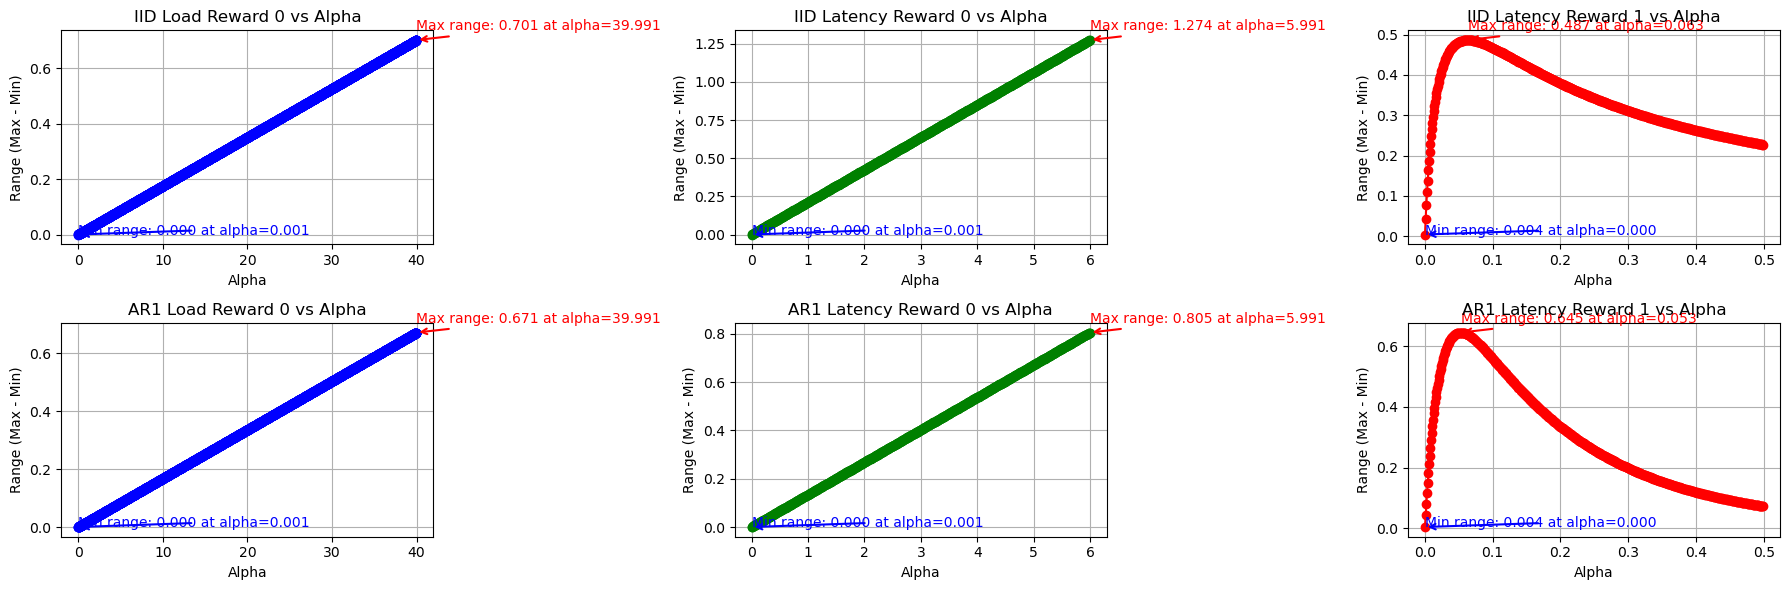

In [8]:
data_processor.plot_range_vs_alpha_interactive()

In [9]:
data_processor.plot_all_distributions_interactive()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='alpha_load_0', layout=Layou…